<a href="https://www.kaggle.com/code/aisuko/fine-tuning-phi-2-with-qlora?scriptVersionId=165487700" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Overview

We are going to fine-tune Microsoft Phi2 using QLoRA in this notebook.

In [1]:
%%capture
!pip install transformers==4.36.2
!pip install accelerate==0.25.0
!pip install datasets==2.15.0
!pip install peft==0.7.1
!pip install bitsandbytes==0.41.3

In [2]:
import os
import torch
from huggingface_hub import login
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
login(token=user_secrets.get_secret("HUGGINGFACE_TOKEN"))

os.environ["WANDB_API_KEY"]=user_secrets.get_secret("WANDB_API_KEY")
os.environ["WANDB_PROJECT"] = "Fine-tuning Microsoft-phi-2"
os.environ["WANDB_NAME"] = "ft-microsoft-phi-2"
os.environ["MODEL_NAME"] = "microsoft/phi-2"
os.environ["DATASET"] = "g-ronimo/riddles_evolved"

torch.backends.cudnn.deterministic=True

Token will not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [3]:
!accelerate estimate-memory ${MODEL_NAME} --library_name transformers

Loading pretrained config for `microsoft/phi-2` from `transformers`...
config.json: 100%|█████████████████████████████| 863/863 [00:00<00:00, 5.54MB/s]
┌────────────────────────────────────────────────────┐
│     Memory Usage for loading `microsoft/phi-2`     │
├───────┬─────────────┬──────────┬───────────────────┤
│ dtype │Largest Layer│Total Size│Training using Adam│
├───────┼─────────────┼──────────┼───────────────────┤
│float32│   500.2 MB  │ 10.37 GB │      41.48 GB     │
│float16│   250.1 MB  │ 5.19 GB  │      20.74 GB     │
│  int8 │  125.05 MB  │ 2.59 GB  │      10.37 GB     │
│  int4 │   62.52 MB  │  1.3 GB  │      5.19 GB      │
└───────┴─────────────┴──────────┴───────────────────┘


# Loading Dataset

In [4]:
from datasets import load_dataset

dataset=load_dataset(os.getenv("DATASET"), split="train[:500]")
dataset=dataset.train_test_split(test_size=0.1)
print(dataset["train"][0])
dataset

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/1682 [00:00<?, ? examples/s]

{'number': 412, 'messages': ['I am a word of six letters, the largest living organism is my kin, You cannot see or touch me, yet you can see all I touch, What am I?', 'The answer to this riddle is "shadow." Shadows are formed when an object blocks the light, preventing it from reaching the ground or surface underneath. Although we cannot see or touch a shadow directly, we can see the objects or areas that cast the shadows. The largest living organism mentioned in the riddle is likely referring to the Armillaria ostoyae, also known as the honey mushroom, which forms the largest living organism by biomass in the world. Is there any specific information you need regarding the honey mushroom or the concept of shadows, or is the answer clear?', "Wow, that's really cool! What's so special about the honey mushroom? Is it edible?", "The honey mushroom, scientifically known as Armillaria ostoyae, is a fascinating organism for several reasons. Its most notable feature is the vast network it form

DatasetDict({
    train: Dataset({
        features: ['number', 'messages'],
        num_rows: 450
    })
    test: Dataset({
        features: ['number', 'messages'],
        num_rows: 50
    })
})

# Loading Tokenizer

* Loading tokenizer
* Adding chatML tokens to tokenizer

In [5]:
from transformers import AutoTokenizer

tokenizer=AutoTokenizer.from_pretrained(os.getenv("MODEL_NAME"), use_fast=False)
print(len(tokenizer))
# add chatML tokens to tokenizer
tokenizer.add_tokens(["<|im_start|>","<PAD>"])
tokenizer.pad_token="<PAD>"
tokenizer.add_special_tokens(dict(eos_token="<|im_end|>"))
print(len(tokenizer))

tokenizer_config.json:   0%|          | 0.00/7.34k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/1.08k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


50295
50298


# Preprocess Data

We are going to apply ChatML format and tokenize to the data.

In [6]:
from functools import partial

templates=[
    '<|im_start|>assistant\n{msg}<|im_end|>',
    '<|im_start|>user\n{msg}<|im_end|>'
]

IGNORE_INDEX=-100

def preprocess_func(input, max_length):
    input_ids, attention_mask, labels=[],[],[]
    for i, msg in enumerate(input["messages"]):
        isHuman=i%2==0
        msg_chatml=templates[isHuman].format(msg=msg)
        msg_tokenized=tokenizer(msg_chatml,truncation=False, add_special_tokens=False)
        
        input_ids+=msg_tokenized["input_ids"]
        attention_mask+=msg_tokenized["attention_mask"]
        labels+=[IGNORE_INDEX]*len(msg_tokenized["input_ids"]) if isHuman else msg_tokenized["input_ids"]

    return {
        "input_ids": input_ids[:max_length],
        "attention_mask": attention_mask[:max_length],
        "labels": labels[:max_length]
    }

dataset_tokenized=dataset.map(
    partial(preprocess_func, max_length=1024), # max sample length 1024 tokens, enough for the dataset
    batched=False,
    num_proc=os.cpu_count(),
    remove_columns=dataset["train"].column_names # do not need this anymore, we have tokens from here on
)

Map (num_proc=4):   0%|          | 0/450 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/50 [00:00<?, ? examples/s]

## Visualization data

Longest sample: 924 tokens


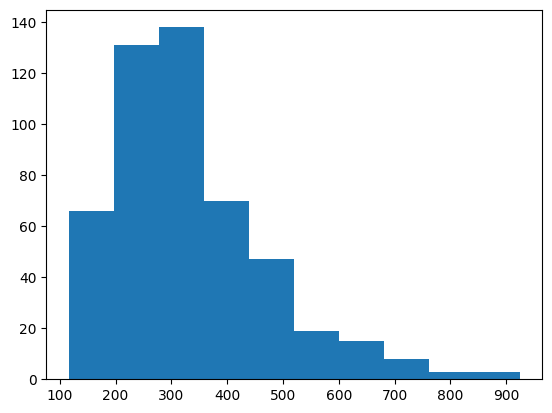

In [7]:
import matplotlib.pyplot as plt

data=[len(tok) for tok in (dataset_tokenized["train"]["input_ids"]+dataset_tokenized["test"]["input_ids"])]
print(f"Longest sample: {max(data)} tokens")

plt.hist(data, bins=10)
plt.show()

# Batch the Data

In [8]:
def collate(example):
    tokens=[e["input_ids"] for e in example]
    tokens_maxlen=max([len(t) for t in tokens])
    
    for i, sample in enumerate(example):
        input_ids=sample["input_ids"]
        labels=sample["labels"]
        attention_mask=sample["attention_mask"]
        
        pad_len=tokens_maxlen-len(input_ids)
        
        input_ids.extend(pad_len*[tokenizer.pad_token_id])
        labels.extend(pad_len*[IGNORE_INDEX])
        attention_mask.extend(pad_len*[0])
        
    batch={
        "input_ids":torch.tensor([e["input_ids"] for e in example]),
        "labels":torch.tensor([e["labels"] for e in example]),
        "attention_mask": torch.tensor([e["attention_mask"] for e in example])
    }
    
    return batch

# Loading Model

* Quantization
* Free the original weights
* LoRA

There is no need to resize the token embeeddings, phi-2 already has embeddings sized for additional tokens. The model's vocabulary size is 51200, this means you can add ~700 tokens to the tokenizer without having to resize the embeddings.

In [9]:
from transformers import AutoModelForCausalLM, BitsAndBytesConfig

bnb_config=BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.bfloat16,
    llm_int8_enable_fp32_cpu_offload=True,
)

model=AutoModelForCausalLM.from_pretrained(
    os.getenv("MODEL_NAME"),
    quantization_config=bnb_config,
    torch_dtype=torch.bfloat16,
    device_map="auto",
    trust_remote_code=True, # for phi-2
)

model.config.eos_token_id=tokenizer.eos_token_id
model.gradient_checkpointing_enable() # reducing memory usage
print(model.model.embed_tokens)

def print_trainable_parameters(model):
    trainable_params=0
    all_params=0
    for _, param in model.named_parameters():
        all_params+=param.numel()
        if param.requires_grad:
            trainable_params+=param.numel()
    print(f"trainable params: {trainable_params} || all params: {all_params} || trainable%: {100 * trainable_params/all_params:.2f}")

print_trainable_parameters(model)

configuration_phi.py:   0%|          | 0.00/9.26k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/phi-2:
- configuration_phi.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_phi.py:   0%|          | 0.00/62.7k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/phi-2:
- modeling_phi.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


model.safetensors.index.json:   0%|          | 0.00/35.7k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/564M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Embedding(51200, 2560)
trainable params: 262364160 || all params: 1521392640 || trainable%: 17.24


# Freeze weigths and apply LoRA

In [10]:
from peft import prepare_model_for_kbit_training

prepared_model=prepare_model_for_kbit_training(
    model, use_gradient_checkpointing=True
)

print_trainable_parameters(prepared_model)
print(prepared_model)

trainable params: 0 || all params: 1521392640 || trainable%: 0.00
PhiForCausalLM(
  (model): PhiModel(
    (embed_tokens): Embedding(51200, 2560)
    (embed_dropout): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0-31): 32 x PhiDecoderLayer(
        (self_attn): PhiAttention(
          (q_proj): Linear4bit(in_features=2560, out_features=2560, bias=True)
          (k_proj): Linear4bit(in_features=2560, out_features=2560, bias=True)
          (v_proj): Linear4bit(in_features=2560, out_features=2560, bias=True)
          (dense): Linear4bit(in_features=2560, out_features=2560, bias=True)
          (rotary_emb): PhiRotaryEmbedding()
        )
        (mlp): PhiMLP(
          (activation_fn): NewGELUActivation()
          (fc1): Linear4bit(in_features=2560, out_features=10240, bias=True)
          (fc2): Linear4bit(in_features=10240, out_features=2560, bias=True)
        )
        (input_layernorm): LayerNorm((2560,), eps=1e-05, elementwise_affine=True)
        (resid_dropo

In [11]:
from peft import LoraConfig, TaskType, get_peft_model

lora_config=LoraConfig(
    r=16,
    lora_alpha=16,
    target_modules=['q_proj', 'k_proj', 'v_proj', 'dense'],
    lora_dropout=0.1,
    bias="none",
    modules_to_save=["lm_head","embed_tokens"], # we added new tokens to tokenizer, this is necesarry
    task_type=TaskType.CAUSAL_LM
)

lora_model=get_peft_model(prepared_model, lora_config)
lora_model.config.use_cache=False
print_trainable_parameters(lora_model)
print(lora_model)

trainable params: 272680960 || all params: 1794073600 || trainable%: 15.20
PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): PhiForCausalLM(
      (model): PhiModel(
        (embed_tokens): ModulesToSaveWrapper(
          (original_module): Embedding(51200, 2560)
          (modules_to_save): ModuleDict(
            (default): Embedding(51200, 2560)
          )
        )
        (embed_dropout): Dropout(p=0.0, inplace=False)
        (layers): ModuleList(
          (0-31): 32 x PhiDecoderLayer(
            (self_attn): PhiAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=2560, out_features=2560, bias=True)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.1, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=2560, out_features=16, bias=False)
                )
                (lora_B): ModuleDict(
                  (defa

# Training

In [12]:
from transformers import set_seed, TrainingArguments, Trainer

set_seed(2024)

bs=2
bs_eval=4
ga_steps=16
lr=0.00002
epochs=2

steps_per_epoch=len(dataset_tokenized["train"])//(bs*ga_steps)

args=TrainingArguments(
    output_dir=os.getenv("WANDB_NAME"),
    per_device_train_batch_size=bs,
    per_device_eval_batch_size=bs_eval,
    evaluation_strategy="steps",
    logging_steps=1,
    eval_steps=steps_per_epoch//2,
    save_steps=steps_per_epoch,
    gradient_accumulation_steps=ga_steps,
    num_train_epochs=epochs,
    lr_scheduler_type="constant",
    optim="paged_adamw_32bit", # val_loss will go nan with paged_adamw_8bit
    learning_rate=lr,
    group_by_length=False,
    fp16=True,
    ddp_find_unused_parameters=False,
    report_to='wandb',
    run_name=os.getenv('WANDB_NAME')
)

trainer=Trainer(
    model=lora_model,
    tokenizer=tokenizer,
    args=args,
    data_collator=collate,
    train_dataset=dataset_tokenized["train"],
    eval_dataset=dataset_tokenized["test"]
)

trainer.train()

2024-03-05 03:08:22.906675: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-05 03:08:22.906808: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-05 03:08:23.075506: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
wandb: Currently logged in as: urakiny (causal_language_trainer). Use `wandb login --relogin` to force relogin


/opt/conda/lib/python3.10/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss
7,1.759000,1.685468
14,1.596400,1.635313
21,1.681900,1.591179
28,1.537300,1.540736


/opt/conda/lib/python3.10/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


TrainOutput(global_step=28, training_loss=1.6597118760858263, metrics={'train_runtime': 1410.4876, 'train_samples_per_second': 0.638, 'train_steps_per_second': 0.02, 'total_flos': 6221645500723200.0, 'train_loss': 1.6597118760858263, 'epoch': 1.99})

In [13]:
from transformers import GenerationConfig

kwargs={
    'model_name': f'{os.getenv("WANDB_NAME")}',
    'finetuned_from': os.getenv('MODEL_NAME'),
#     'tasks': '',
#     'dataset_tags':'',
    'dataset': os.getenv("DATASET")
}

generation_config=GenerationConfig(
    max_new_tokens=100,
    temperature=0.7,
    top_p=0.1,
    top_k=40,
    repetition_penalty=1.18,
    do_sample=True,
    pad_token_id=tokenizer.pad_token_id,
    eos_token_id=tokenizer.eos_token_id
)

generation_config.save_pretrained('aisuko/'+os.getenv('WANDB_NAME'), push_to_hub=True)
tokenizer.push_to_hub(os.getenv("WANDB_NAME"))
trainer.push_to_hub(**kwargs)

training_args.bin:   0%|          | 0.00/4.73k [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/1.09G [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

CommitInfo(commit_url='https://huggingface.co/aisuko/ft-microsoft-phi-2/commit/d187c09f68635333f0b1aa31da8971fee17d446a', commit_message='End of training', commit_description='', oid='d187c09f68635333f0b1aa31da8971fee17d446a', pr_url=None, pr_revision=None, pr_num=None)

# Inference

In [19]:
import gc

del tokenizer, lora_model, prepared_model, model

gc.collect()
torch.cuda.empty_cache()

In [20]:
tokenizer=AutoTokenizer.from_pretrained(os.getenv("MODEL_NAME"), use_fast=False)
tokenizer.add_tokens(["<|im_start|>","<PAD>"])
tokenizer.pad_token="<PAD>"
tokenizer.add_special_tokens(dict(eos_token="<|im_end|>"))

tokenizer.chat_template="{% if not add_generation_prompt is defined%}{% set add_generation_prompt=false%}{%endif%}{%for message in messages%}{{'<|im_start|>'+message['role']+message['content']+'<|im_end|>'}}{%endfor%}{%if add_generation_prompt%}{{'<|im_start|>assistant'}}{%endif%}"

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [22]:
model=AutoModelForCausalLM.from_pretrained(os.getenv("MODEL_NAME"), torch_dtype=torch.bfloat16,trust_remote_code=True, device_map="auto")
model.config.eos_token_id=tokenizer.eos_token_id

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [25]:
from peft import PeftModel

generation_config=GenerationConfig(
    max_new_tokens=100,
    temperature=0.7,
    top_p=0.1,
    top_k=40,
    repetition_penalty=1.18,
    do_sample=True,
    pad_token_id=tokenizer.pad_token_id,
    eos_token_id=tokenizer.eos_token_id
)

model=PeftModel.from_pretrained(model, os.getenv("WANDB_NAME"))
model=model.merge_and_unload()

question="Hello, Who are you"
messages=[{"role":"user","content":question}]

input_tokens=tokenizer.apply_chat_template(
    messages,
    add_generation_prompt=True,
    return_tensors="pt"
).to('cuda')

output_tokens=model.generate(input_tokens)
output=tokenizer.decode(output_tokens[0][len(input_tokens[0]):], skip_special_tokens=True)
print(output)

In [31]:
model.save_pretrained(os.getenv("WANDB_NAME"), safe_serialization=True, max_shared_size="4GB")

model.push_to_hub(os.getenv("WANDB_NAME"))
tokenizer.save_pretrained(os.getenv("WANDB_NAME"), push_to_hub=True)
generation_config.save_pretrained(os.getenv("WANDB_NAME"), push_to_hub=True)

# Reference List

* https://medium.com/@geronimo7/phinetuning-2-0-28a2be6de110
* https://github.com/geronimi73/phi2-finetune/blob/main/nb_qlora.ipynb
* https://www.kaggle.com/code/aisuko/text-summarization-with-bart-series-llm
* https://www.kaggle.com/code/aisuko/fine-tuning-microsoft-phi2